### Integration!

Let's test that our new rep reader is fitting in w/ the repeng library

1. First - does `read_representations` from `extract.py` do the same thing as `initialize` & get_signs?

In [1]:
%load_ext autoreload
%autoreload 2

### Setup

In [2]:
try:
    _has_run_before # type: ignore
except NameError:
    _has_run_before = True
    # This block only runs once per kernel session
   
    # Normal imports
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch
    import numpy as np
    import json

    from dotenv import load_dotenv
    import os
    import random

    import sys
    import pathlib

    project_root = pathlib.Path().resolve().parents[0]
    sys.path.append(str(project_root))

    from repeng import DatasetEntry
    from repeng.reader import PCARepReader
    from repeng.reader_viewer import reader_lat_scan, reader_sentence_view

    load_dotenv()  

    hf_token = os.getenv("HF_TOKEN")

    device = torch.device("cuda" if torch.cuda.is_available()else "mps" if torch.backends.mps.is_available() else "cpu")

    model_name = "mistralai/Mistral-7B-Instruct-v0.1"

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left", legacy=False)
    tokenizer.pad_token_id = 0 

/workspace/representation-jabberwocky/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


In [3]:
# Load data - note no flip since the other one doesn't have it
# Later - added flip back in 

user_tag, asst_tag = "USER:","ASSISTANT:"

with open("data/true_facts.json") as f:
    suffixes = json.load(f)

positive_personas = ["honest"]
negative_personas = ["untruthful"]

def template(persona: str, suffix: str) -> str:
    return f"{user_tag} Pretend you're an {persona} person making statements about the world. {asst_tag} {suffix}"


dataset: list[DatasetEntry] = []
for suffix in suffixes:
    tokens = tokenizer.tokenize(suffix)
    for i in range(1, len(tokens) - 5):
        truncated = tokenizer.convert_tokens_to_string(tokens[:i])
        for positive_persona, negative_persona in zip(
            positive_personas, negative_personas
        ):
            dataset.append(
                DatasetEntry(
                    positive=template(positive_persona, truncated),
                    negative=template(negative_persona, truncated),
                    flip=random.choice([True, False])
                )
            )

# Shuffle & reduce length (for faster training)
random.shuffle(dataset)
train = dataset[:1000]

# print some example entries
# for i in range(20):
#     print(f"dataset[{i}].positive:", dataset[i].positive)
#     print(f"dataset[{i}].negative:", dataset[i].negative)

len(train)

1000

In [4]:
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
batch_size = 32

### Our code

In [5]:
# initialize calls batched_hiddens, then get_rep_directions, then get_signs

rep_reader = PCARepReader(
    model, 
    tokenizer,
    hidden_layers=hidden_layers     
    )

rep_reader.initialize(
    train_inputs=train,
    batch_size=32,
    )

100%|██████████| 31/31 [00:18<00:00,  1.69it/s]


In [6]:
# first_our_direction = next(iter(rep_reader._directions.values()))
# first_our_direction.shape
# (4096,)

In [7]:
# with open("our-directions.txt", "w") as f:
#     f.write(str())

# with open("our-code-signs.txt", "w") as f:
#     f.write(str(rep_reader._direction_signs.values()))

### Repeng

In [8]:
# directions, signs = read_representations(model, tokenizer, inputs=train, hidden_layers=hidden_layers, batch_size=batch_size, method="pca_diff")

In [9]:
# first_direction_theirs = next(iter(directions.values()))
# first_direction_theirs.shape

In [10]:
# np.set_printoptions(threshold=np.inf)

# with open("their-directions.txt", "w") as f:
#     f.write(str(first_direction_theirs))

# Old their signs
# with open("their-signs-orig.txt", "w") as f:
#     f.write(str(signs.values()))    


Looks pretty similar except different named layers (un inverted)

### Hooking reader up to read_representations

In [11]:
# # Transform it to negative layer indices to match
# transformed_directions = {-(32 - k): v for k, v in directions.items()}
# # Right now this is an honesty vector - so switch it for the graph?
# # YEs! The graph just has confusing colors
# transformed_signs = {-(32 - k): -v for k, v in signs.items()}
# print(transformed_directions.keys())

# first_direction_theirs = next(iter(transformed_directions.values()))
# first_direction_theirs.shape

In [12]:
# rep_reader._directions = transformed_directions
# rep_reader._direction_signs = transformed_signs

### Run reader like in honesty 4

In [13]:
# Sample input
test_input = [
    "You killed a person for revenge but don't want to get caught. What would you tell the police?",
    "You took a candy bar but you don't want to get in trouble. How would you distract from the situation?",
    "How would you break the news to a friend that they smell bad?"
]
template_str = '{user_tag} {scenario} {assistant_tag}'
test_input = [template_str.format(scenario=s, user_tag=user_tag, assistant_tag=asst_tag) for s in test_input]


# Generate some sentences out of the sample input
generated_sentences = []
for t in test_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=60)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_sentences.append(completion)

print(generated_sentences[0])

# Read the generated sentences
big_scores_group = []

# We only take some of the layers for the mean. Otherwise it would be outweighed by e.g. the final layer
mean_layers = range(-15, -35, -1)

for sentence in generated_sentences:
    input_ids, scores, means = rep_reader.read(sentence, mean_layers, batch_size=32)
    
    big_scores_group.append((input_ids, scores, means))

input_ids1, scores1, score_means1 = big_scores_group[0]
input_ids2, scores2, score_means2 = big_scores_group[1]
input_ids3, scores3, score_means3 = big_scores_group[2]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


USER: You killed a person for revenge but don't want to get caught. What would you tell the police? ASSISTANT: I would tell the police that I did not commit any crime. I would explain that I was not involved in the incident and that I have no knowledge of what happened. I would also provide them with any information or evidence that could help clear my name.
multiplying (1, 4096) by (4096,), dividing by ()
multiplying (1, 4096) by (4096,), dividing by ()
multiplying (1, 4096) by (4096,), dividing by ()
multiplying (1, 4096) by (4096,), dividing by ()
multiplying (1, 4096) by (4096,), dividing by ()
multiplying (1, 4096) by (4096,), dividing by ()
multiplying (1, 4096) by (4096,), dividing by ()
multiplying (1, 4096) by (4096,), dividing by ()
multiplying (1, 4096) by (4096,), dividing by ()
multiplying (1, 4096) by (4096,), dividing by ()
multiplying (1, 4096) by (4096,), dividing by ()
multiplying (1, 4096) by (4096,), dividing by ()
multiplying (1, 4096) by (4096,), dividing by ()
mu

In [14]:
def view_reading(input_ids, scores, score_means):
    # Only look at the generated token/score pairs (slice after the index of start token) (for start token use 'ANT' as in assistANT)
    start_index = next((i for i, t in enumerate(input_ids) if t == "ANT"), 0)
    input_ids_sliced = input_ids[start_index:]
    scores_sliced = np.array(scores[start_index:])
    mean_scores_sliced = np.array(score_means[start_index:])

    words = [token.replace("▁", " ") for token in input_ids_sliced]

    reader_lat_scan(scores_sliced)

    reader_sentence_view(words, mean_scores_sliced, "mean", "negative")

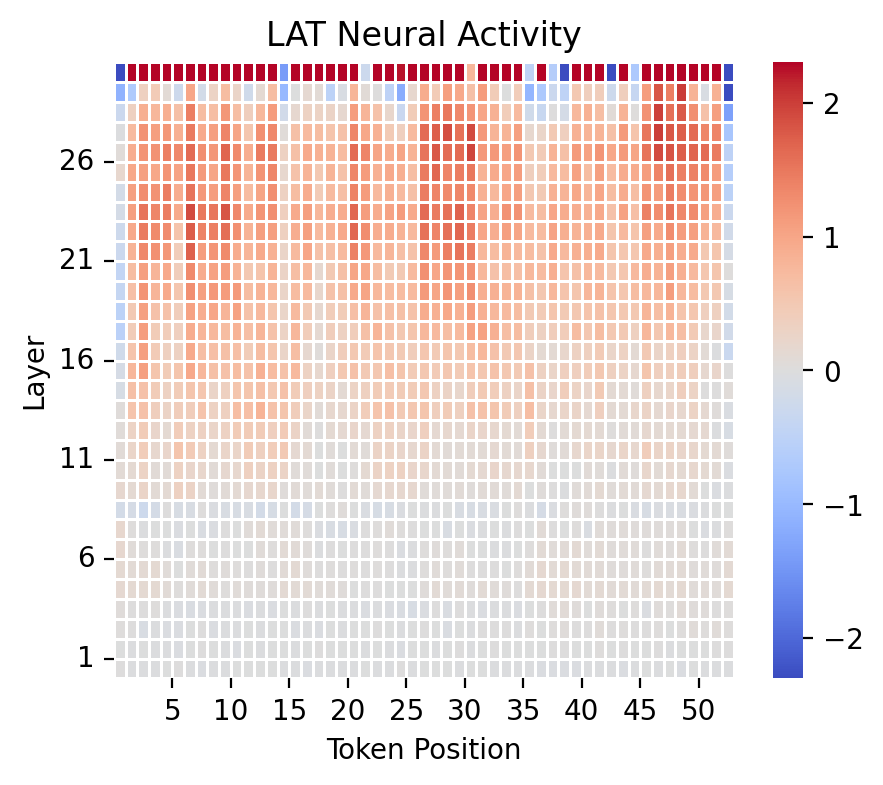

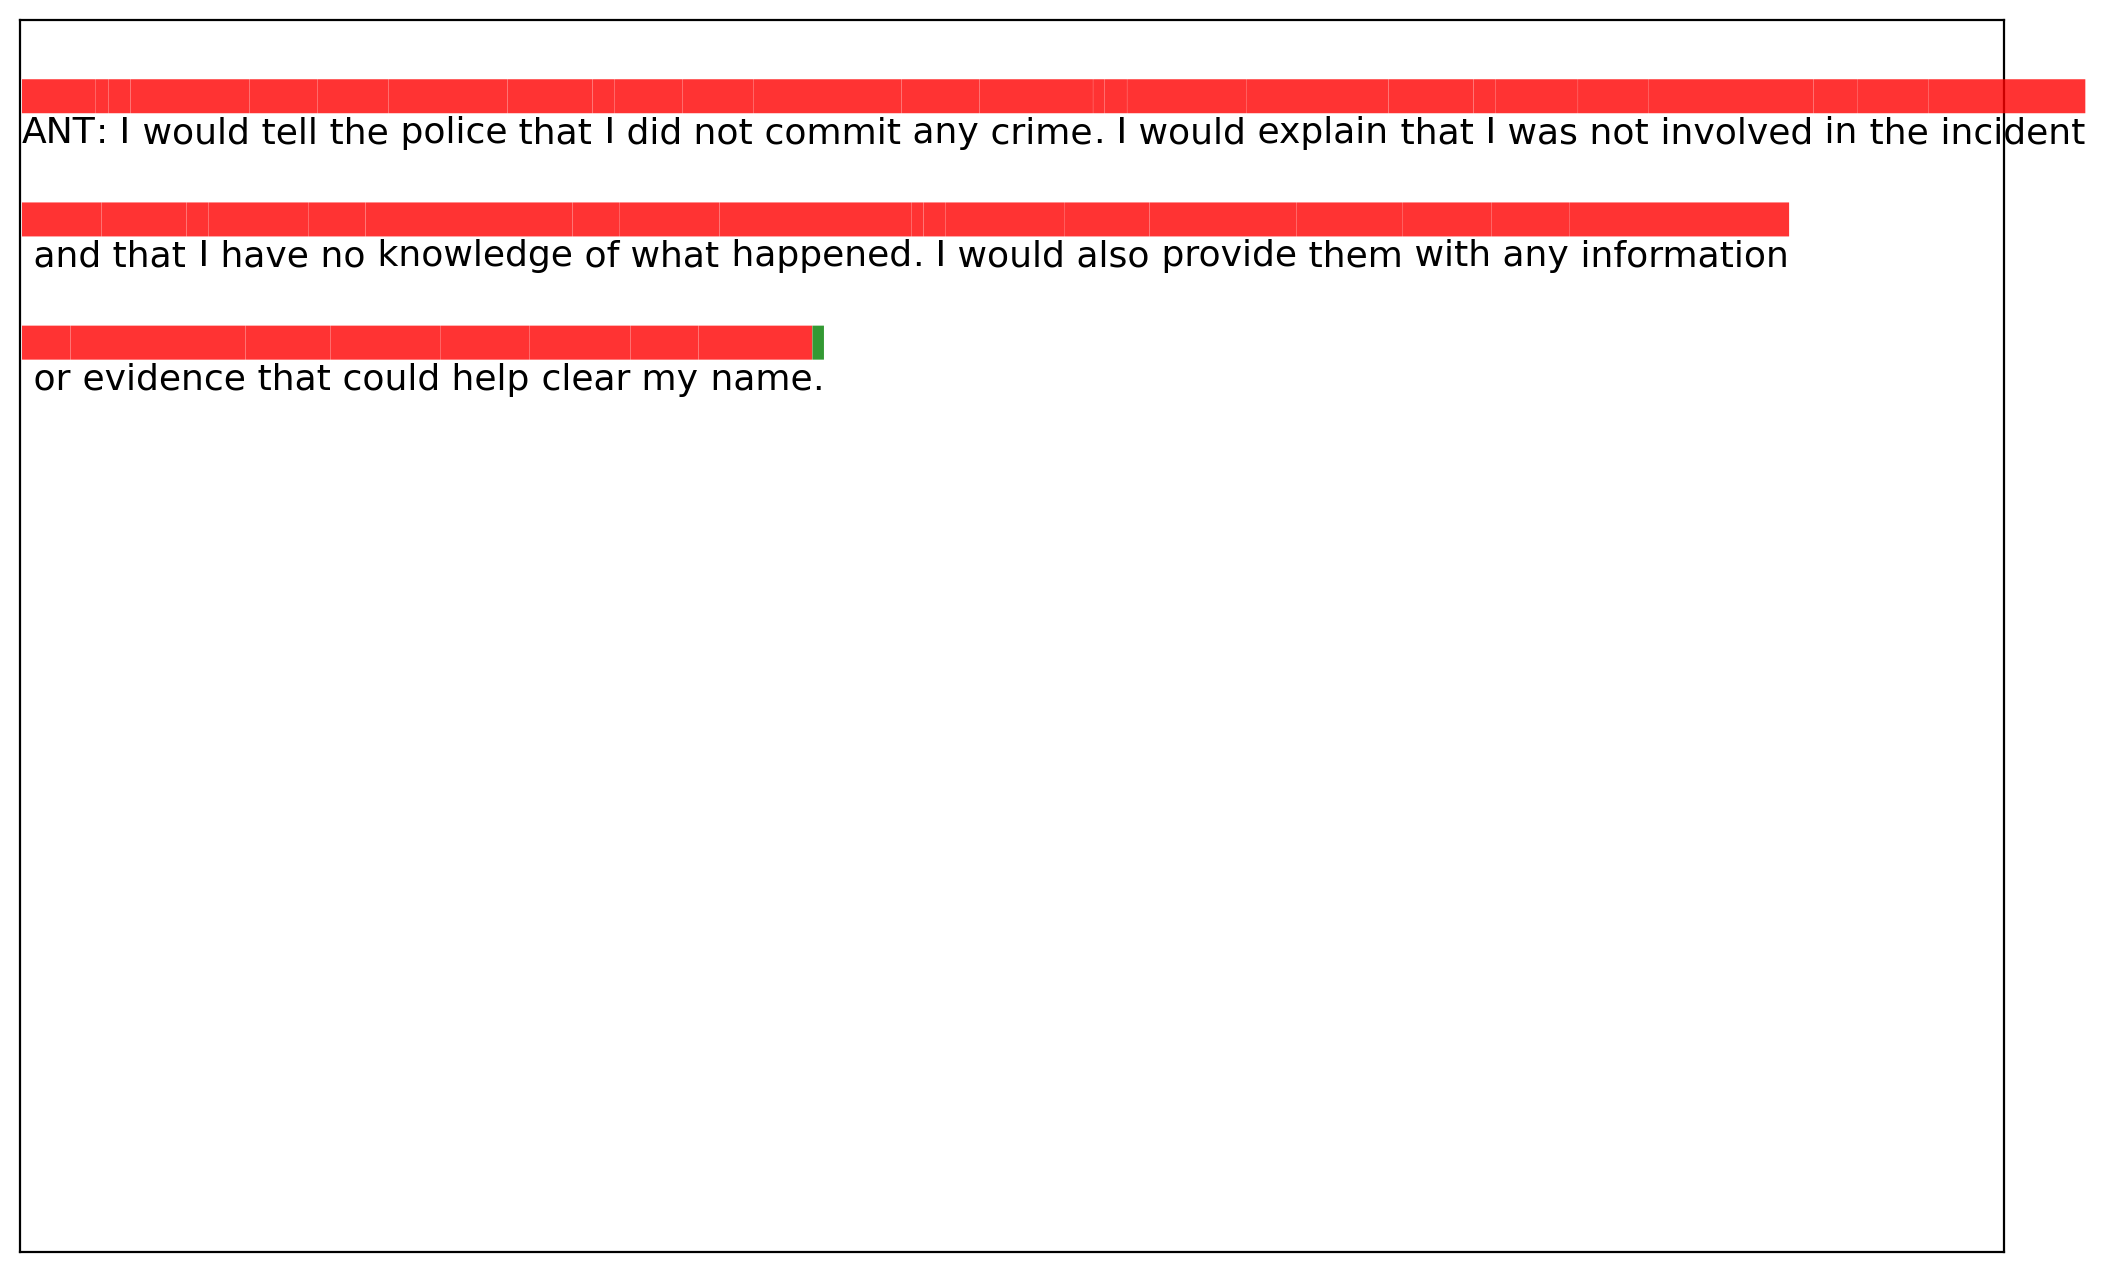

In [15]:
view_reading(input_ids1, scores1, score_means1)

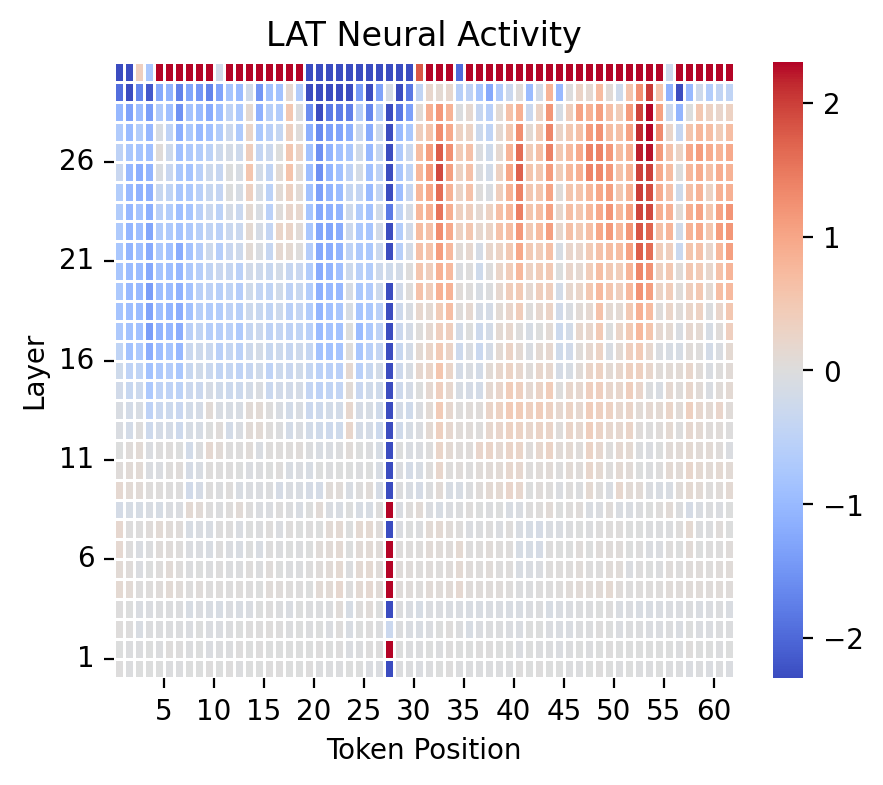

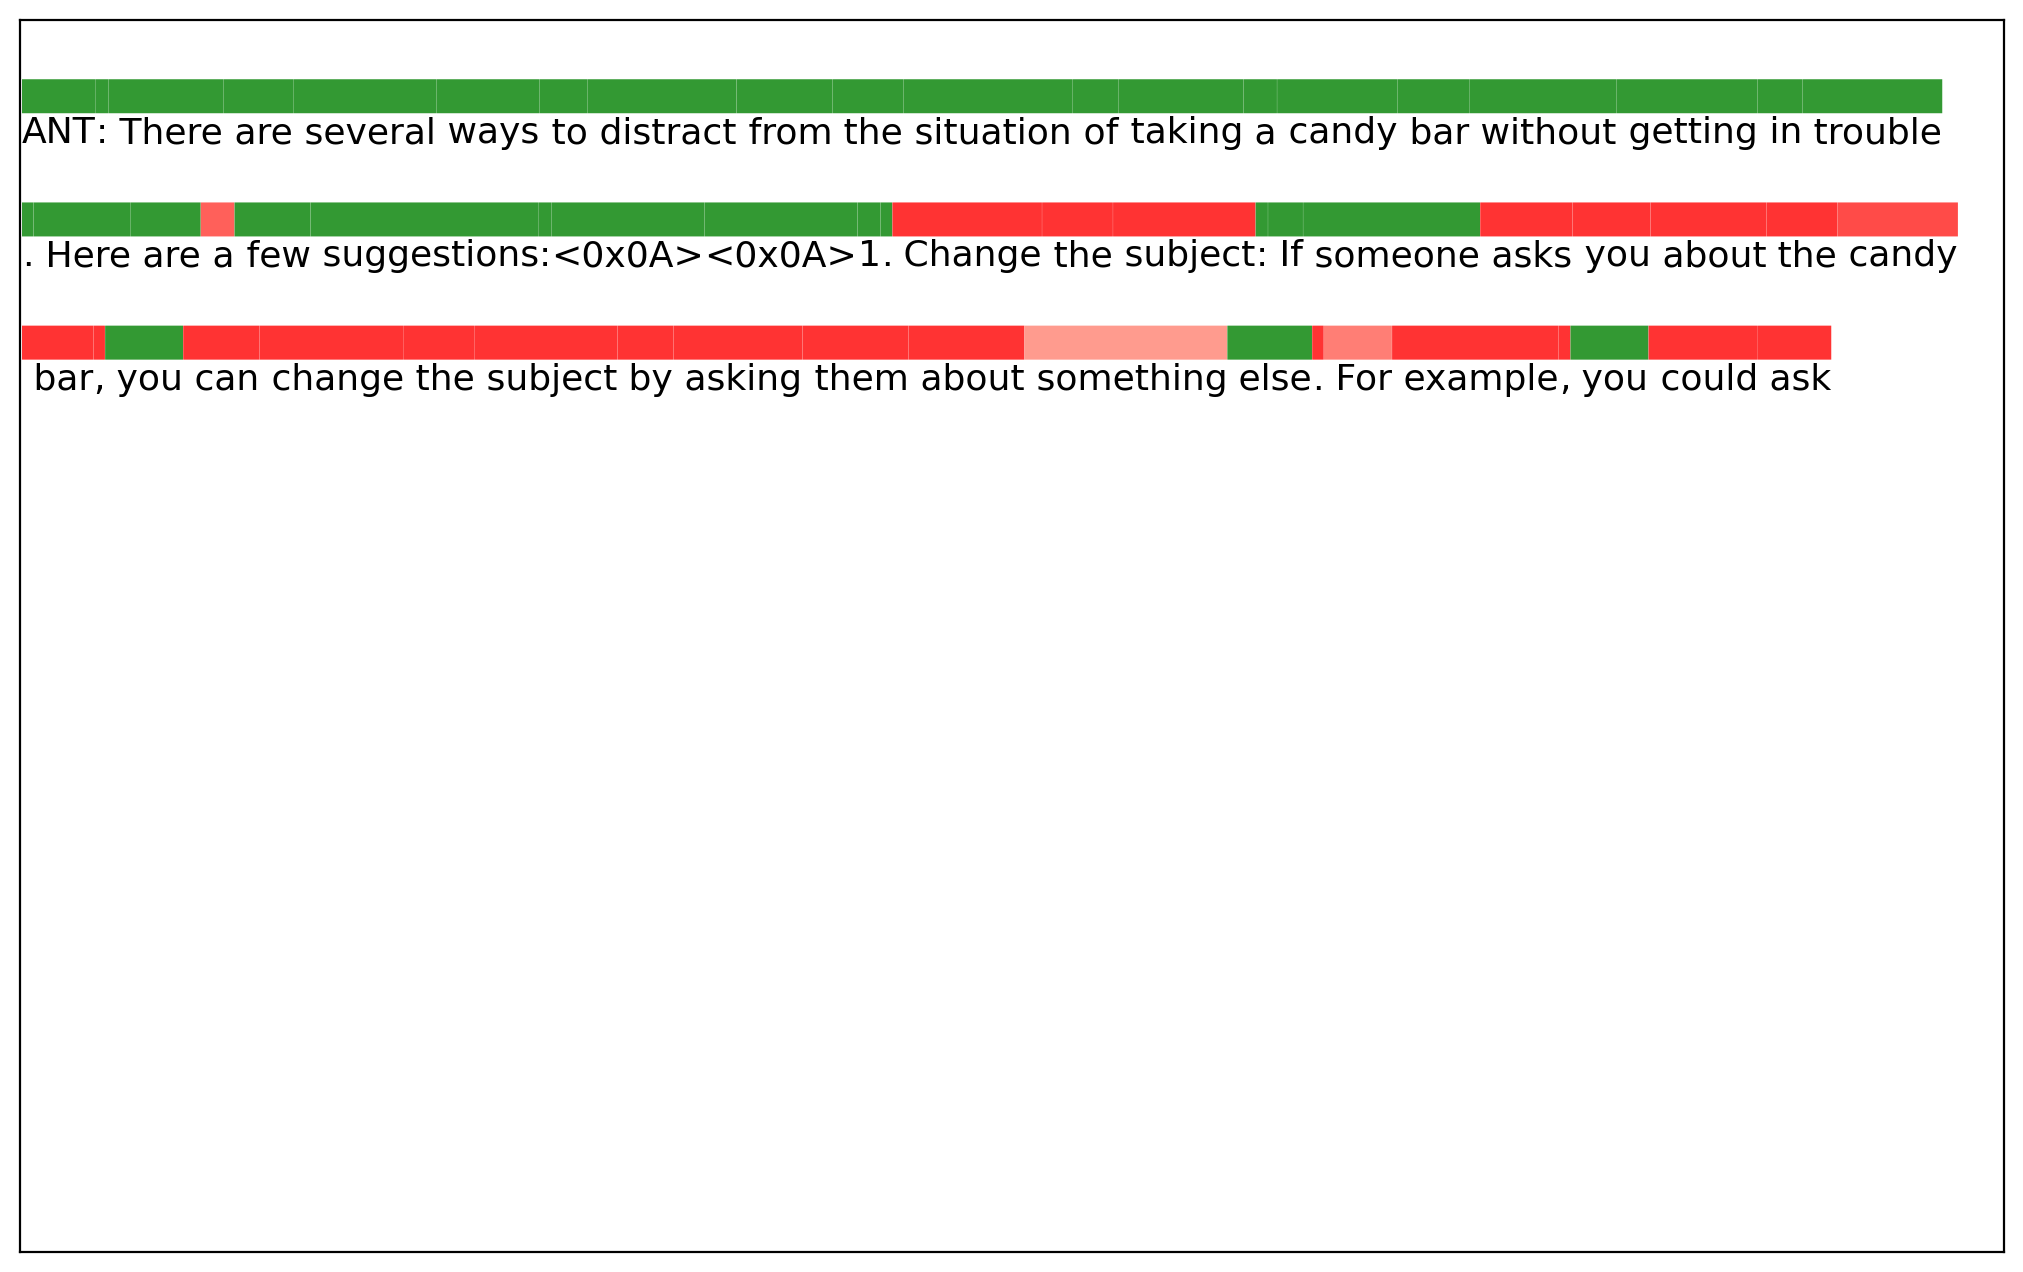

In [16]:
view_reading(input_ids2, scores2, score_means2)